# 5. Basic Image processing: Filtering, scaling, thresholding

Almost all image processing pipelines start with some basic procedures like thresholding, intensity rescaling, filtering etc. Also methods such as those relying on machine learning very often require a pre-processing step of that type.

Let us import again all necessary packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from aicsimageio import AICSImage

Most filtering functions will come out from the filters module of scikit-image:

In [2]:
import skimage.filters

A specific region size/shape has often to be specified for filters. Those are defined in the morphology module:

In [3]:
import skimage.morphology

Additionally, this module offers a set of binary operators essential to operate on the masks resulting from segmentation.

We will start working on a single plane of the dataset seen in chapter [3](03-Image_import.ipynb)

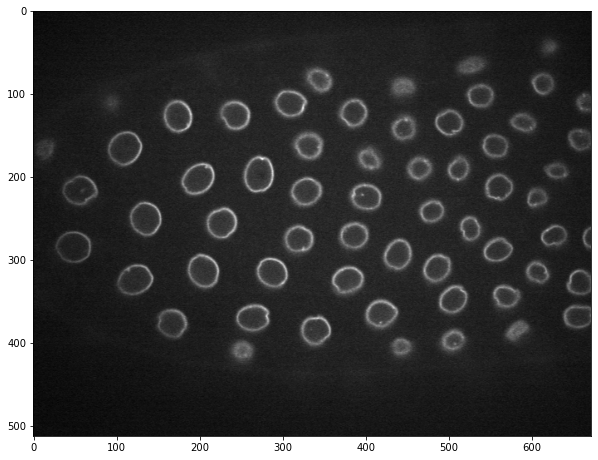

In [6]:
#load image
data = AICSImage('../Data/30567/30567.tif')
image = data.get_image_data("YX", C=0, T=0, Z=3) 

#plot image
plt.figure(figsize=(10,10))
plt.imshow(image,cmap = 'gray');

## 5.1 Filtering

Filtering is a local operation, where an image is transformed by applying a specific function to a region around each pixel. For example a mean filter of size 2, calculates for each pixel the median value of the 2x2 region around it:

<img src="illustrations/filtering.gif" alt="" style="width: 60%"/>

The most common filters are classified as linear or non-linear. Here linear means that the filtered values are some linear combination of the regions considered around pixels, and included e.g. mean and gaussian filters. The second use non-linear combinations of pixel values such as a median. A sub-category of non-linear filters are binary morphological filters that are often used to clean segmentation mask and that are discussed in the [05-Binary_operations.ipynb](05-Binary_operations.ipynb) chapter.

For all filters, one needs to either define the values of the filter (e.g. as defined in a gaussian filter) or its size and shape. For the latter case, skimage offers a series of pre-made shapes:

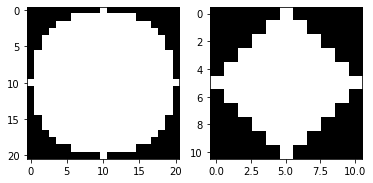

In [7]:
disk = skimage.morphology.disk(10)
diamond  = skimage.morphology.diamond(5)
plt.subplot(1,2,1)
plt.imshow(disk,cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(diamond,cmap = 'gray');

Using an image and such a filter shape (or selection element), one can then apply a filter such as the median filter:

In [8]:
image_mean = skimage.filters.median(image,selem=skimage.morphology.disk(3))

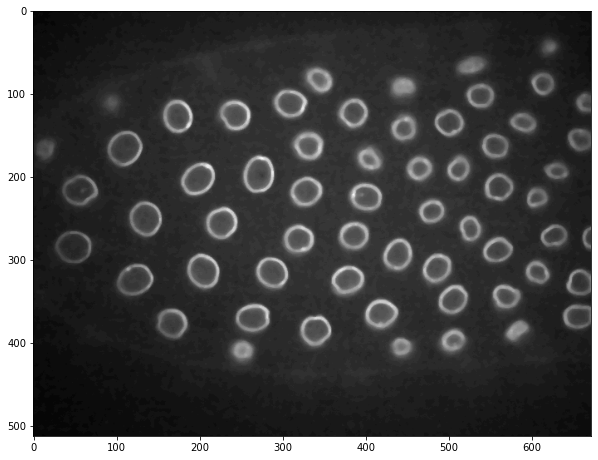

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(image_mean,cmap = 'gray');

skimage offers a vast choice of filter to use: sum, min, mean, gaussian, laplacian etc. In general filters are used either to reduce noise in the image (by removing pixel outliers) or to highlight specific objects or features in the image.

In the latter category one finds e.g. the Sobel filter that highlights edges or the Frangi filter that highlights vessels.

In [10]:
image_gradienth = skimage.filters.sobel(image)
image_gradientv = skimage.filters.sobel_v(image)
image_gradient = np.sqrt(image_gradientv**2+image_gradienth**2)

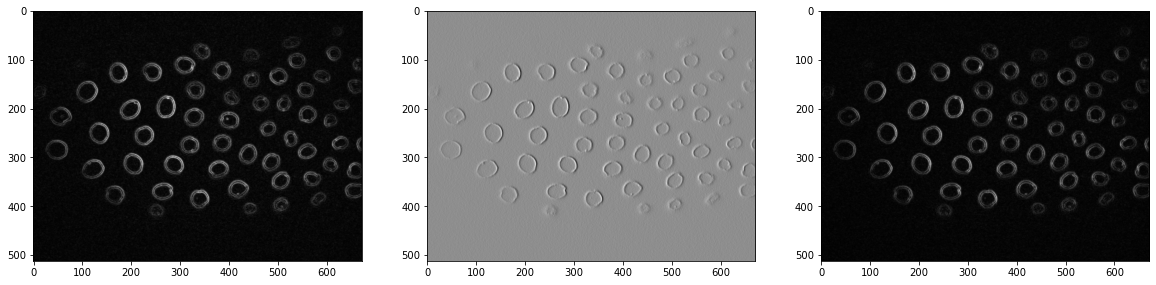

In [11]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(image_gradienth,cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(image_gradientv,cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(image_gradient,cmap = 'gray');

As mentioned before, some filters require parameters to be set. One of the simplest examples is the Gaussian filter whose width can be set using the standard deviation for example with teh value: $\sigma = 10$:

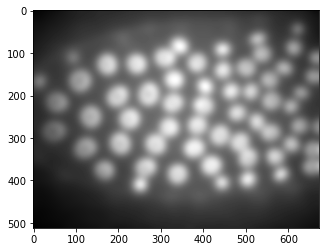

In [12]:
image_gauss = skimage.filters.gaussian(image, sigma=10)
plt.imshow(image_gauss,cmap = 'gray');

A warning regarding filters: some filters can change the type and even the range of intensity of the image. Typically the gaussian filter used above rescales the image between 0 and 1:

In [13]:
print(image.dtype)
print(image.max())
print(image.min())

uint16
20303
2827


In [14]:
print(image_gauss.dtype)
print(image_gauss.max())
print(image_gauss.min())

float64
0.12531917375072713
0.054386287321711344


In many cases, one can specify whether the original range should be preserved:

float64
8212.792051753902
3564.2053396283527


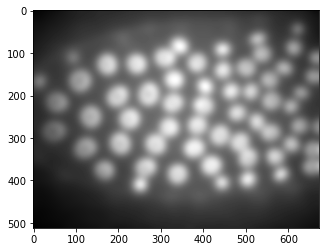

In [15]:
image_gauss_preserve = skimage.filters.gaussian(image, sigma=10, preserve_range=True)
plt.imshow(image_gauss_preserve,cmap = 'gray');
print(image_gauss_preserve.dtype)
print(image_gauss_preserve.max())
print(image_gauss_preserve.min())

## 5.2 Intensity re-scaling

A very common operation to do in an image processing pipeline, is to rescale the intensity of images. The reasons can be diverse: for example, one might want to remove an offset added to each pixel by the camera, or one might want to homogenize multiple images with slightly varying exposures.

The simplest thing to do is to rescale from min to max in the range 0-1. To create a histogram of the pixel values of an image, we first have to "flatten" the array, i.e. remove the dimensions, so that the plotting function doesn't believe we have a series of separate measurements.

In [16]:
np.ravel(image).shape

(344064,)

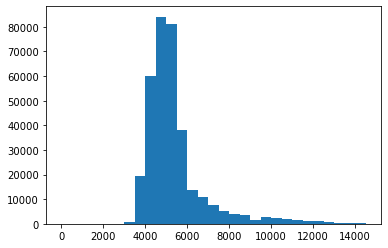

min val: 2827
max val: 20303


In [17]:
plt.hist(np.ravel(image), bins = np.arange(0,15000,500))
plt.show()
print("min val: "+ str(np.min(image)))
print("max val: "+ str(np.max(image)))

In [18]:
image_minmax = (image-image.min())/(image.max()-image.min())
image_minmax[image_minmax>1] = 1

One problem that might emerge is that a few pixels might be affected by rare noise events that give them abnormal values. One way to remedy that is to use a small median filter in order to suppress those aberrant values:

In [19]:
image_median = skimage.filters.median(image,selem=np.ones((2,2)))
print("min val: "+ str(np.min(image_median)))
print("max val: "+ str(np.max(image_median)))

image_median_rescale = (image_median-image_median.min())/(image_median.max()-image_median.min())
image_median_rescale[image_minmax>1] = 1

min val: 3084
max val: 20046


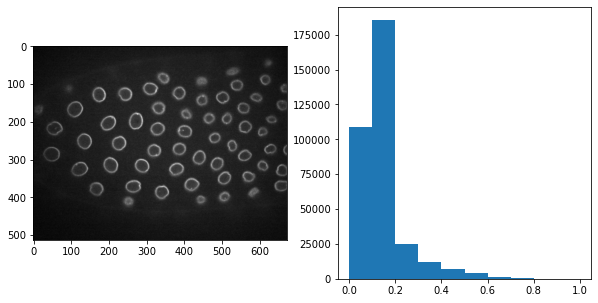

In [20]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image_median_rescale,cmap = 'gray')
plt.subplot(1,2,2)
plt.hist(np.ravel(image_median_rescale))#, bins = np.arange(0,15000,500))
plt.show()

Note that this manual rescaling that we performed can be done directly via the module ```skimage.exposure``` which offers several function to adjust the intensity distribution. The simple min-max rescaling for example is done like this:

In [21]:
im_rescale_skimage = skimage.exposure.rescale_intensity(image_median.astype(float), in_range='image', out_range=(0,1))

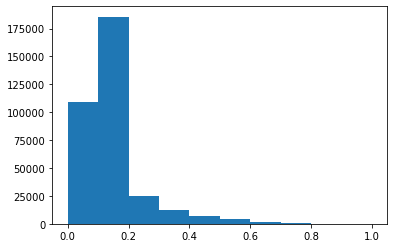

In [22]:
plt.hist(np.ravel(im_rescale_skimage));

## 5.3 Thresholding

Another common operation is to try isolating regions of an image based on their intensity by using an intensity threshold: one can create a maks object where all values larger than a threshold are 1 and the other 0. It is usually better to use a smoothed version of the image (e.g. median or gaussian filtering) to avoid including noisy pixels in the maks.

Let us imagine that we want to isolate the nuclei in our current image. To do that we can try to use their bright contour. Based on the intensity histogram, let's try to pick a threshold manually:

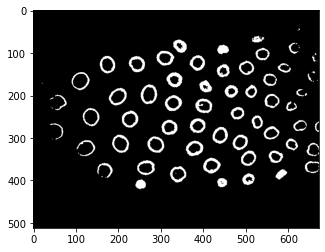

In [23]:
threshold_manual = 8000

#create a mask using a logical operation
image_threshold = image_median > threshold_manual

plt.imshow(image_threshold, cmap ='gray')
plt.show()

Instead of picking manually the threshold, one can (should) use an automated method to define it. These methods perform an analysis of the intensity distribution and determine the threshold position based on some class separation metric. Skimage implements many thresholding algorithms, for example the popular Otsu threshold:

In [24]:
image_otsu_threshold = skimage.filters.threshold_otsu(image_median)

In [25]:
image_otsu_threshold

7196

In [26]:
image_otsu_threshold = skimage.filters.threshold_otsu(image_median)
print(image_otsu_threshold)
image_li_threshold = skimage.filters.threshold_li(image_median)
print(image_li_threshold)

7196
6416.599708799512


Knowing that threshold value we can create a binary image setting all pixels higher than the threshold to 1.

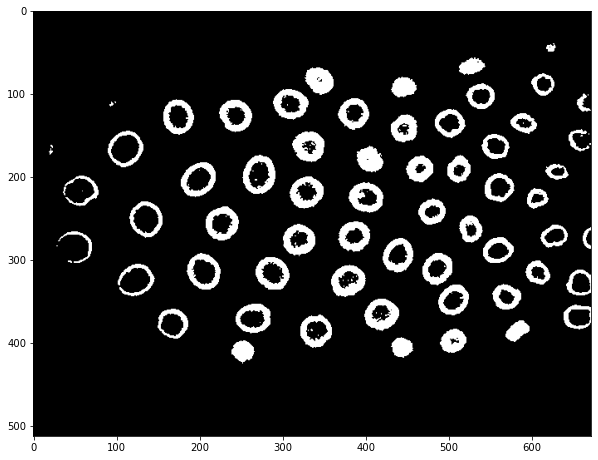

In [27]:
image_otsu = image_median > image_otsu_threshold
plt.figure(figsize=(10,10))
plt.imshow(image_otsu, cmap = 'gray')
plt.show()

If one isn't sure what thresholdin method is the most appropriate, one can verify all of them in one step using the ```skimage.filters.try_all_threshold``` function.

Since in our example the illumination is uneven across the image, all standard thresholding methods are going to fail in some region of the image. What we could try to do instead is using a local thresholding, by repeating a standard thresholding method in sub-regions of the image:

In [28]:
image_local_threshold = skimage.filters.threshold_local(image_median,block_size=51)

In [29]:
image_local_threshold.shape

(512, 672)

In [30]:
image_local_threshold = skimage.filters.threshold_local(image_median,block_size=51)
image_local = image_median > image_local_threshold

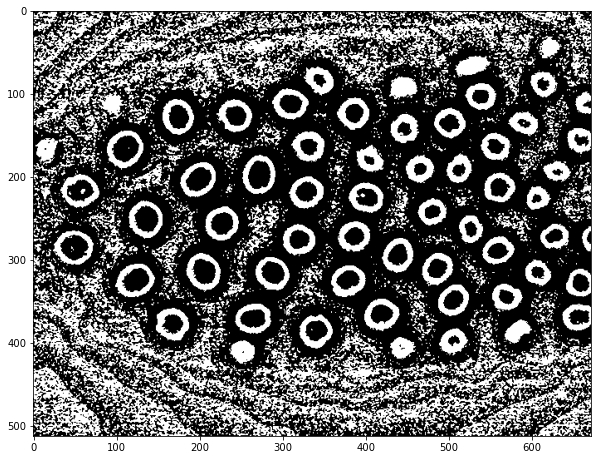

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(image_local, cmap = 'gray')
plt.show()

We see that now each contour of the nuclei is recovered much better, however there is a lot of spurious background signal.

## 5.4 Note on higher-dimensional cases

Some functions of scikit-image are only designed for 2D images, and will generate an error message when used with 3D images. An alternative package to use in those cases is scipy and specifically scipy.ndimage and scipy.filtering